# ViT from scratch

In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [42]:
import einops
from einops import rearrange, reduce, repeat
from skimage import data
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class MyViT(nn.Module):
    def __init__(self):
        # Super constructor
        super(MyViT, self).__init__()

    def forward(self, images):
        pass

![ViT architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

*`The architecture of the ViT with specific details on the transformer encoder and the MSA block. Keep this picture in mind. Picture from Bazi et. al.`*


## Let’s build the ViT in 6 main steps.

Step 1: Patchifying and the linear mapping

In [4]:
# def patchify(images, n_patches):
#     n, c, h, w = images.shape

#     assert h == w, "Patchify method is implemented for square images only"

#     patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
#     patch_size = h // n_patches

#     for idx, image in enumerate(images):
#         for i in range(n_patches):
#             for j in range(n_patches):
#                 patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
#                 patches[idx, i * n_patches + j] = patch.flatten()
#     return patches

In [5]:
# import torch

# def patchify(images, n_patches):
#     n, c, h, w = images.shape

#     assert h == w, "Patchify method is implemented for square images only"

#     patch_size = h // n_patches
#     patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
#     patches = patches.contiguous().view(n, -1, c * patch_size * patch_size)

#     return patches

In [6]:


# def patchify(images, n_pathces):
#     """
#     Example:

#         x = torch.randn(1,1, 28,28)
#         rearrange(x, 'b c (h p1) (w p2) ->b p1 p2 c h w', p1=7, p2=7).shape

#         #Result: torch.Size([1, 7, 7, 1, 4, 4])

#         # We got 1 7x7 patched image totalling 49 patches, and each of the holding 4x4x1 (HxWxC) pixels.

#     """
#     b, c, h, w = images.shape
#     assert h == w, "Patchify method is implemented for square images only"
#     p1 = p2 = n_pathces

#     return rearrange(x, 'b c (h p1) (w p2) ->b (p1 p2 c) (h w)', p1=p1, p2=p2)


![link text](https://miro.medium.com/v2/resize:fit:640/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)
Raffiguration of how an image is split into patches. The 1x28x28 image is split into 49 (7x7) patches, each of size 16 (4x4x1) pixels.


$(N, PXP, ((H/P) X (W/P) X C)) = (N, 7X7, (4X4X1)) = (N, 49, 16)$

In [43]:
import torch
from einops import rearrange

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patch_size = h // n_patches

    # Rearrange the tensor to create patches directly
    patches = rearrange(images, 'n c (i p1) (j p2) -> n (i j) (c p1 p2)', i=n_patches, j=n_patches, p1=patch_size, p2=patch_size)

    return patches

In [44]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()
    super().__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches

In [45]:
if __name__ == '__main__':
    B,C,H,W = 1, 1, 512, 512
    p = 8
    # Current model
    model = MyViT(
    chw=(C,H,W),
    n_patches=p
    )

    x = torch.randn(B, C, H, W) # Dummy images
    print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([1, 64, 4096])


In [47]:
def compute_vit_patchify_dims(B,C,H,W,p):
    # B,C,H,W = 1, 1, 28, 28
    # p = 7
    print(f"({B,C,H,W} | {p}) ->{B, p*p, (H//(p), W//(p), C)}")

    print(f"({B,C,H,W} | {p}) ->{B, p*p, H*W*C//(p**2)}")

    print(f"The flatten vector shape : {H*W*C//(p**2)} pixels will become input_channel  to the Linear Projector")

In [48]:
B,C,H,W = 1,1,512,512
p = 8

compute_vit_patchify_dims(B,C,H,W,p)

((1, 1, 512, 512) | 8) ->(1, 64, (64, 64, 1))
((1, 1, 512, 512) | 8) ->(1, 64, 4096)
The flatten vector shape : 4096 pixels will become input_channel  to the Linear Projector


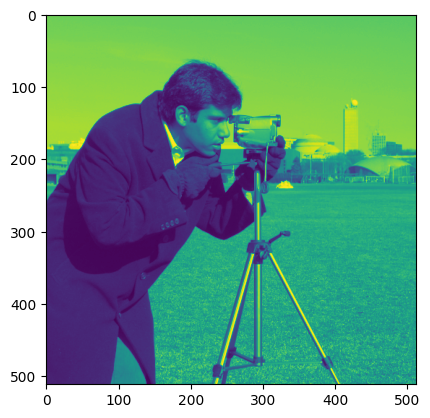

In [49]:
camera = data.camera()
plt.imshow(camera)

In [50]:
I =Image.fromarray(camera).convert('L')

In [51]:
x = np.expand_dims(np.array(I), axis=(0, 1))
x = torch.tensor(x, dtype=torch.float16)

In [52]:
x.shape

torch.Size([1, 1, 512, 512])

In [55]:
if __name__ == '__main__':
  B,C,H,W = 1,1,512,512
  p = 8
  # Current model
  model = MyViT(
  chw=(C,H,W),
  n_patches=p
  )

#   x = torch.randn(7, 1, 28, 28) # Dummy images
patches = model(x)
print(patches.shape) # torch.Size([7, 49, 16])

torch.Size([1, 64, 4096])


In [56]:
patches.shape

torch.Size([1, 64, 4096])

### Let's visualize these patches as a grid to see the whole image as grid of patches

64
torch.Size([64, 64, 64])


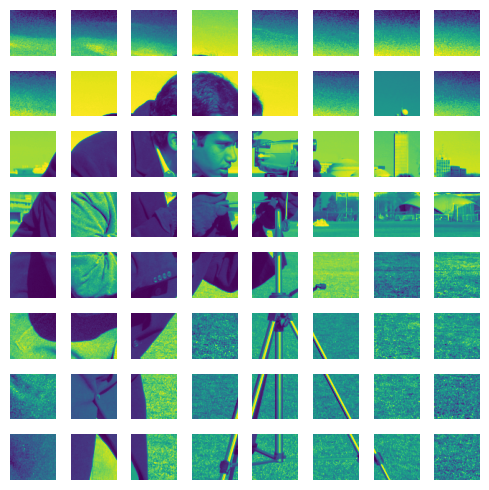

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming your patches are stored in a tensor named patches
# patches = torch.randn(64, 4096)  # Replace this with your actual patches

# Define the size of each patch
patch_size = int(np.sqrt(patches.shape[2]))
print(patch_size)
# Reshape the patches to 2D images (assuming the patches are square)
patches_reshaped = patches.view(-1, patch_size, patch_size)
print(patches_reshaped.shape)

# Create a grid size for plotting
grid_size = int(np.sqrt(patches.shape[1]))

# Create a figure for the grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# Ensure axes is an iterable of axes objects
if grid_size == 1:
    axes = np.array([[axes]])

# Plot each patch in the grid
for (i, j), ax in np.ndenumerate(axes):
    ax.imshow(patches_reshaped[i * grid_size + j])
    ax.axis('off')

plt.tight_layout()
plt.show()



### Let's add patch numbers to verify the image integrity

In [58]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming your patches are stored in a tensor named patches
# # patches = torch.randn(64, 4096)  # Replace this with your actual patches

# # Define the size of each patch
# patch_size = int(np.sqrt(patches.shape[2]))
# print(patch_size)
# # Reshape the patches to 2D images (assuming the patches are square)
# patches_reshaped = patches.view(-1, patch_size, patch_size)
# print(patches_reshaped.shape)

# # Create a grid size for plotting
# grid_size = int(np.sqrt(patches.shape[1]))

# # Create a figure for the grid
# fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# # Ensure axes is an iterable of axes objects
# if grid_size == 1:
#     axes = np.array([[axes]])

# # # Plot each patch in the grid
# # for (i, j), ax in np.ndenumerate(axes):
# #     ax.imshow(patches_reshaped[i * grid_size + j])
# #     ax.axis('off')

# # plt.tight_layout()
# # plt.show()


# # Plot each patch in the grid and add numbers
# for (i, j), ax in np.ndenumerate(axes):
#     idx = i * grid_size + j
#     ax.imshow(patches_reshaped[idx])
#     ax.text(5, 5, str(idx), color='red', fontsize=12, ha='center', va='center')
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [59]:
patches.shape

torch.Size([1, 64, 4096])

In [60]:
patches[0]

tensor([[200., 200., 200.,  ..., 207., 206., 206.],
        [198., 196., 197.,  ..., 208., 207., 208.],
        [197., 196., 197.,  ..., 199., 198., 198.],
        ...,
        [131., 141., 134.,  ..., 133., 176., 146.],
        [144., 163., 135.,  ..., 150., 139., 171.],
        [152., 144., 142.,  ..., 151., 152., 149.]], dtype=torch.float16)

In [61]:
for i, p in enumerate(patches.squeeze()):
    print(f"{i}-> {p.shape}")

0-> torch.Size([4096])
1-> torch.Size([4096])
2-> torch.Size([4096])
3-> torch.Size([4096])
4-> torch.Size([4096])
5-> torch.Size([4096])
6-> torch.Size([4096])
7-> torch.Size([4096])
8-> torch.Size([4096])
9-> torch.Size([4096])
10-> torch.Size([4096])
11-> torch.Size([4096])
12-> torch.Size([4096])
13-> torch.Size([4096])
14-> torch.Size([4096])
15-> torch.Size([4096])
16-> torch.Size([4096])
17-> torch.Size([4096])
18-> torch.Size([4096])
19-> torch.Size([4096])
20-> torch.Size([4096])
21-> torch.Size([4096])
22-> torch.Size([4096])
23-> torch.Size([4096])
24-> torch.Size([4096])
25-> torch.Size([4096])
26-> torch.Size([4096])
27-> torch.Size([4096])
28-> torch.Size([4096])
29-> torch.Size([4096])
30-> torch.Size([4096])
31-> torch.Size([4096])
32-> torch.Size([4096])
33-> torch.Size([4096])
34-> torch.Size([4096])
35-> torch.Size([4096])
36-> torch.Size([4096])
37-> torch.Size([4096])
38-> torch.Size([4096])
39-> torch.Size([4096])
40-> torch.Size([4096])
41-> torch.Size([4096])
42

/tmp/ipykernel_4426/1539803236.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


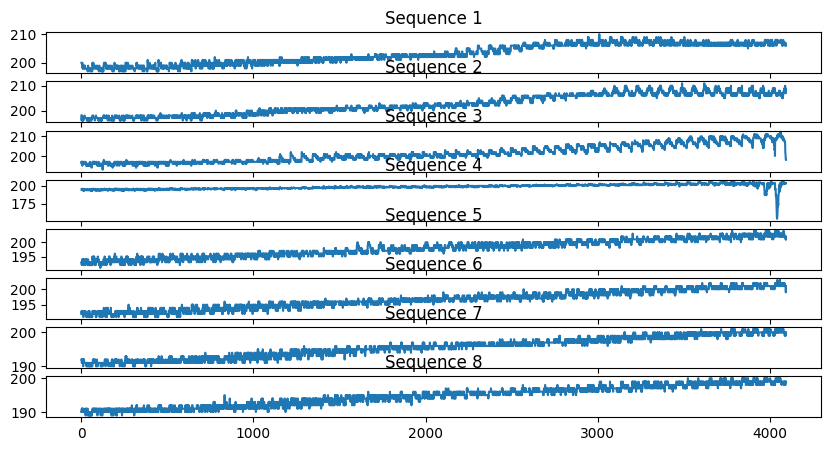

In [65]:
import torch
import matplotlib.pyplot as plt

# Sample tensor
# tensor = torch.randn(1, 16, 16384)

# Convert tensor to numpy array for plotting
p = patches.squeeze().numpy()

# Plot a few sequences from the data
fig, axes = plt.subplots(8, 1, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.plot(p[i])
    ax.set_title(f'Sequence {i+1}')

plt.tight_layout()
plt.show()